Mapping particle tracks from Ocean Parcels unto the Salish Sea Atlantis Boxes. 
Original code written by Bec Gordon & Javier Porobic, CSIRO.
Link to the [SSAM Ocean Parcels Repo](https://bitbucket.csiro.au/users/por07g/repos/ssam_oceanparcels/browse)

In [110]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from netCDF4 import Dataset
from shapely.geometry import Point, Polygon, MultiPoint

In [2]:
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
box_area = data_df['AREA']
#box_volume = box_area * box_depth
#surface_volume = box_area * 25

#print(box_volume)

In [3]:
data_df

,cat,BOUNDARY,BOTZ,Region,Sub_Basins,PSmodel,vertmix,horizmix,PERIMETER,list,AREA,DisplayDep,geometry
BOX_ID,,,,,,,,,,,,,
0,119,1,400,Boundary,Main Basin,No,0.0,1.0,57419.0,NaN,97362056,-1.0,"POLYGON ((-124.71244 48.59717, -124.70793 48.5..."
1,48,0,50,Juan de Fuca,Main Basin,No,0.0,1.0,19721.0,1.0,655575973,50.0,"POLYGON ((-124.71244 48.59717, -123.52445 48.3..."
2,49,0,100,Juan de Fuca,Main Basin,No,0.0,1.0,14480.0,2.0,682702420,100.0,"POLYGON ((-124.70793 48.54075, -123.96270 48.3..."
3,120,0,100,Juan de Fuca,Main Basin,No,0.0,1.0,20347.0,NaN,494069246,100.0,"POLYGON ((-124.69970 48.43773, -123.96270 48.2..."
4,37,0,100,Juan de Fuca,Main Basin,No,0.0,1.0,96558.0,4.0,446328916,100.0,"POLYGON ((-123.51285 48.28257, -123.47959 48.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,114,0,0,Island,Johnson strait island,No,0.0,1.0,46792.0,NaN,60940418,0.0,"POLYGON ((-125.12770 50.12882, -125.14511 50.1..."
126,115,0,0,Island,Johnson strait island,No,0.0,1.0,69501.0,NaN,144127317,0.0,"POLYGON ((-124.92793 50.18117, -124.89472 50.1..."
127,116,0,0,Island,Johnson strait island,No,0.0,1.0,11185.0,NaN,305171650,0.0,"POLYGON ((-124.97876 50.25572, -124.95843 50.2..."


In [4]:
surface_layer = []
for box in range(0,130):
    if data_df.iloc[box].BOTZ < 26:
        layer = 0
    elif data_df.iloc[box].BOTZ == 50:
        layer = 1
    elif data_df.iloc[box].BOTZ == 100:
        layer = 2
    elif data_df.iloc[box].BOTZ == 200:
        layer = 3
    elif data_df.iloc[box].BOTZ > 200 and box_depth[box] < 401:
        layer = 4
    elif data_df.iloc[box].BOTZ > 400:
        layer = 5
    surface_layer.append(layer)

In [5]:
len(surface_layer)

130

In [6]:
# Ocean Parcels Spill File

inputFileName = '5b_TurnPoint_Dilbit_2019-01-20'
file_path = 'results/' + inputFileName + '_10000_OP_D50_wp3.zarr'
num_particles = 10000

In [7]:
scenario = inputFileName.split(sep = '_')

In [8]:
# Oil type properties & spill location selection

Dilbit = {
    "Density": 1011.2, #kg/m^3
    "Naphthalene": 24, #mg/kg oil
    "Phenanthrene": 17,
    "Pyrene": 10,
    "Benzo": 3,
}

BunkerC = {
    "Density": 995.3,
    "Naphthalene": 680,
    "Phenanthrene": 796,
    "Pyrene": 266,
    "Benzo": 56,
}

Diesel = {
    "Density": 831.0,
    "Naphthalene": 3664,
    "Phenanthrene": 1000,
    "Pyrene": 0.000,
    "Benzo": 0.000,
}

Crude = {
    "Density": 884.7,
    "Naphthalene": 654,
    "Phenanthrene": 327,
    "Pyrene": 13,
    "Benzo": 2,
}

fuel_type = {
    "Dilbit" : Dilbit,
    "BunkerC" : BunkerC,
    "Diesel" : Diesel,
    "Crude" : Crude,
}

spill_volume = {
    "5b" : 2000, #m^3 
    "6a" : 15,
    "7a" : 1000,
    "4a" : 500,
}

spill_box_surface_volume = {
    "5b" : (322271112.331102*25), #m^3 area x surface depth
    "6a" : (108463283.03614*25),
    "7a" : (663754967.760742*25),
    "4a" : ((289374380+143789739)/2*25),
}

In [9]:
# Calculations of oil per particle in mg/m^3/particle
release_start = scenario[3]
oil_per_particle = (fuel_type[scenario[2]]["Density"] * spill_volume[scenario[0]] / spill_box_surface_volume[scenario[0]]) / num_particles #kg/m3
naph_per_particle = oil_per_particle * fuel_type[scenario[2]]["Naphthalene"] 
phen_per_particle = oil_per_particle * fuel_type[scenario[2]]["Phenanthrene"]
pyrene_per_particle = oil_per_particle * fuel_type[scenario[2]]["Pyrene"]
benzo_per_particle = oil_per_particle * fuel_type[scenario[2]]["Benzo"]
release_start_time = np.datetime64(release_start)

In [10]:
# Calculations of oil mass in mg
oil_mass_kg = (fuel_type[scenario[2]]["Density"] * spill_volume[scenario[0]])
naph_mass_mg = oil_mass_kg * fuel_type[scenario[2]]["Naphthalene"]
phen_mass_mg = oil_mass_kg * fuel_type[scenario[2]]["Phenanthrene"]
pyrene_mass_mg = oil_mass_kg * fuel_type[scenario[2]]["Pyrene"]
benzo_mass_mg = oil_mass_kg * fuel_type[scenario[2]]["Benzo"]
oil_mass_mg = oil_mass_kg * 1e6

print(str(scenario[2])+' spill mass of '+str(oil_mass_mg)+' in mg')
print('Naphthalene spill mass of '+str(naph_mass_mg)+' in mg')
print('Phenanthrene spill mass of '+str(phen_mass_mg)+' in mg')
print('Pyrene spill mass of '+str(pyrene_mass_mg)+' in mg')
print('Benzo spill mass of '+str(benzo_mass_mg)+' in mg')

Dilbit spill mass of 2022400000000.0 in mg
Naphthalene spill mass of 48537600.0 in mg
Phenanthrene spill mass of 34380800.0 in mg
Pyrene spill mass of 20224000.0 in mg
Benzo spill mass of 6067200.0 in mg


In [11]:
# Calculating the surface concentration of each contaminant for the entire spill
oil_full = oil_per_particle * num_particles * 1e6 / spill_box_surface_volume[scenario[0]]
naph_full = naph_per_particle * num_particles
phen_full = phen_per_particle * num_particles
pyrene_full = pyrene_per_particle * num_particles
benzo_full = benzo_per_particle * num_particles

print(str(scenario[2])+' spill concentration of '+str(oil_full)+' in mg/m^3')
print('Naphthalene spill concentration of '+str(naph_full)+' in mg/m^3')
print('Phenanthrene spill concentration of '+str(phen_full)+' in mg/m^3')
print('Pyrene spill concentration of '+str(pyrene_full)+' in mg/m^3')
print('Benzo spill concentration of '+str(benzo_full)+' in mg/m^3')

Dilbit spill concentration of 3.115618565968159e-08 in mg/m^3
Naphthalene spill concentration of 0.006024443165123948 in mg/m^3
Phenanthrene spill concentration of 0.004267313908629464 in mg/m^3
Pyrene spill concentration of 0.0025101846521349783 in mg/m^3
Benzo spill concentration of 0.0007530553956404935 in mg/m^3


In [12]:
numLayers = 7
numSites = data_df.shape[0]
numTargetSites = numSites

#outputDT = 60*60
outputDT = 43100.00

stepsPerDay = int(86400.0/ outputDT)
numStepsPerDT = int(outputDT/3600.0)

debug = False

In [13]:
pfile = xr.open_zarr(file_path) #.to_netcdf(new_file_name)

In [14]:
#an array of times that correspond to Atlantis timesteps
time_slice = np.arange(0,len(pfile.time[0]),12) #or any N

In [15]:
pfile

<xarray.Dataset>
Dimensions:      (trajectory: 10007, obs: 238)
Coordinates:
  * obs          (obs) int32 0 1 2 3 4 5 6 7 ... 230 231 232 233 234 235 236 237
  * trajectory   (trajectory) int64 105 129 ... -9223372036854775808
Data variables:
    age          (trajectory, obs) float64 dask.array<chunksize=(212, 1), meta=np.ndarray>
    beached      (trajectory, obs) float64 dask.array<chunksize=(212, 1), meta=np.ndarray>
    decay_value  (trajectory, obs) float32 dask.array<chunksize=(212, 1), meta=np.ndarray>
    lat          (trajectory, obs) float64 dask.array<chunksize=(212, 1), meta=np.ndarray>
    lon          (trajectory, obs) float64 dask.array<chunksize=(212, 1), meta=np.ndarray>
    time         (trajectory, obs) datetime64[ns] dask.array<chunksize=(212, 1), meta=np.ndarray>
    z            (trajectory, obs) float64 dask.array<chunksize=(212, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.2

In [83]:
reduced_pfile = pfile.isel(obs=(time_slice))

In [84]:
reduced_pfile

<xarray.Dataset>
Dimensions:      (trajectory: 10007, obs: 20)
Coordinates:
  * obs          (obs) int32 0 12 24 36 48 60 72 ... 156 168 180 192 204 216 228
  * trajectory   (trajectory) int64 105 129 ... -9223372036854775808
Data variables:
    age          (trajectory, obs) float64 dask.array<chunksize=(212, 1), meta=np.ndarray>
    beached      (trajectory, obs) float64 dask.array<chunksize=(212, 1), meta=np.ndarray>
    decay_value  (trajectory, obs) float32 dask.array<chunksize=(212, 1), meta=np.ndarray>
    lat          (trajectory, obs) float64 dask.array<chunksize=(212, 1), meta=np.ndarray>
    lon          (trajectory, obs) float64 dask.array<chunksize=(212, 1), meta=np.ndarray>
    time         (trajectory, obs) datetime64[ns] dask.array<chunksize=(212, 1), meta=np.ndarray>
    z            (trajectory, obs) float64 dask.array<chunksize=(212, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.2

In [88]:
reduced_pfile.time[0,:].values

array(['2019-01-20T00:00:00.000000000', '2019-01-20T12:00:00.000000000',
       '2019-01-21T00:00:00.000000000', '2019-01-21T12:00:00.000000000',
       '2019-01-22T00:00:00.000000000', '2019-01-22T12:00:00.000000000',
       '2019-01-23T00:00:00.000000000', '2019-01-23T12:00:00.000000000',
       '2019-01-24T00:00:00.000000000', '2019-01-24T12:00:00.000000000',
       '2019-01-25T00:00:00.000000000', '2019-01-25T12:00:00.000000000',
       '2019-01-26T00:00:00.000000000', '2019-01-26T12:00:00.000000000',
       '2019-01-27T00:00:00.000000000', '2019-01-27T12:00:00.000000000',
       '2019-01-28T00:00:00.000000000', '2019-01-28T12:00:00.000000000',
       '2019-01-29T00:00:00.000000000', '2019-01-29T12:00:00.000000000'],
      dtype='datetime64[ns]')

In [112]:
lats = reduced_pfile['lat'][:,0].values
lons = reduced_pfile['lon'][:,0].values

In [113]:
points = np.column_stack((lons, lats))

In [114]:
points.shape

(10007, 2)

In [115]:
multi_point = MultiPoint(points)

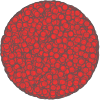

In [116]:
multi_point

In [18]:
# applying to all veraibles now
lon = reduced_pfile.variables['lon']
lat = reduced_pfile.variables['lat']
time = pfile.variables['time'][:,time_slice]
z = pfile.variables['z'][:,time_slice]

In [20]:
numParticles = lon.shape[0]
numParticles

10007

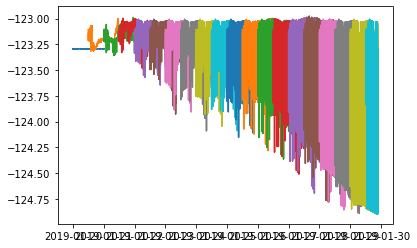

In [23]:
import matplotlib.pyplot as plt
plt.plot(time[5:], lon[5:]);

In [24]:
numParticles = lon.shape[0]
minDate = np.datetime64(release_start+"T00:30:00")
ts = pd.to_datetime(str(minDate))
d = ts.strftime('%Y-%m-%d %H:%M:%S')
print(d)

2019-01-20 00:30:00


In [118]:
# TEST
for box_number in range (59, 61):
    layer = surface_layer[box_number]
    box_coordinates = data_df.iloc[box_number].geometry
    found_particles = np.array([box_coordinates.contains(point) for point in multi_point])
    num_particles_within_box = np.sum(found_particles)
    print(f"Number of particles within {box_number}: {num_particles_within_box}")

Number of particles within 59: 0
Number of particles within 60: 10000


ORIGINAL CODE TO BE MODIFIED BELOW

In [17]:
numReleaseDays = 1
numReleaseSteps = numReleaseDays * stepsPerDay

trackLength = len(lon[0])

print('trackLength = ' + str(trackLength))
print('numStepsPerDT = ' + str(numStepsPerDT))
numSteps = int(trackLength / numStepsPerDT)


trackLength = 238
numStepsPerDT = 11


In [18]:
# Create the netcdf output file

netcdfFileName = "SSAM_Scenario_"+scenario[1]+"_"+ scenario[3] + "_" + str(num_particles) + "_fromzarr.nc"
try:
    os.remove(netcdfFileName)
except:
    pass
ncfile = Dataset(netcdfFileName, "w", format="NETCDF4", clobber=True)
Dataset.set_fill_on(ncfile)

# Dimensions
t = ncfile.createDimension("t", None)
b = ncfile.createDimension("b", numTargetSites)
z = ncfile.createDimension("z", numLayers)

In [19]:
# Variables
times = ncfile.createVariable("t",np.float64, ("t",))
oil = ncfile.createVariable("oil",np.float64,("t", "b"))
Naphthalene = ncfile.createVariable("Naphthalene",np.float64, ("t", "b", "z"))
Phenanthrene = ncfile.createVariable("Phenanthrene",np.float64,("t", "b", "z"))
Pyrene = ncfile.createVariable("Pyrene",np.float64,("t", "b", "z"))
Benzo = ncfile.createVariable("Benzo",np.float64,("t", "b", "z"))

# Attributes
Naphthalene.units = "mgPAH/m^3"
Naphthalene.long_name = "Naphthalene"
Naphthalene.missing_value = 0.0000
Naphthalene.valid_min = 0.0000
Naphthalene.valid_max = 100000000.0

Phenanthrene.units = "mgPAH/m^3"
Phenanthrene.long_name = "Phenanthrene"
Phenanthrene.missing_value = 0.0000
Phenanthrene.valid_min = 0.0000
Phenanthrene.valid_max = 100000000.0

Pyrene.units = "mgPAH/m^3"
Pyrene.long_name = "Pyrene"
Pyrene.missing_value = 0.0000
Pyrene.valid_min = 0.0000
Pyrene.valid_max = 100000000.0

Benzo.units = "mgPAH/m^3"
Benzo.long_name = "Benzo(a)pyrene"
Benzo.missing_value = 0.0000
Benzo.valid_min = 0.0000
Benzo.valid_max = 100000000.0

oil.units = "kgOil/m^3"
oil.long_name = "Oil"

times.units = "seconds since " + d
times.dt = outputDT
times.long_name = "time"

In [20]:
# Populate variables with contaminant data

timeData = np.arange(0,(numSteps + numReleaseSteps)*outputDT,outputDT)
times[:] = timeData

No_layer_particles = np.zeros((numSteps + numReleaseSteps, numTargetSites))
Surface_particles = np.zeros((numSteps + numReleaseSteps, numTargetSites, numLayers))

I wish to change the following code
- for each Atlantis timestep of 12 hours
    - for each Atlantis box (128 in all)
        - sum the number of particles in the zarr file that falls inside the box geometry
        - determine which layer is the surface_layer of that Atlantis box
        - record summation of particles from the zarr file in Surface_particles[timestep-12h][box_id][surface_layer]


Changes suggested by Doug
- find a way to operate in arrays
- find a way to make the timestep into 12 steps and reduce the data file to the timesteps I want

In [ ]:


for timeValue in range(0, numSteps):

    partLon = lon.value[:,timeValue]
    partLat = lat.value[:,timeValue]

    for box_number in range (0, 130):

        layer = surface_layer[box_number]
        box_coordinates = data_df.iloc[box_number].geometry
        find_particle = box_coordinates.contains(Point(partLon, partLat))

        if find_particle:
            Surface_particles[timeValue][box_number][layer] = Surface_particles[timeValue][box_number][layer] + find_particle.sum
            No_layer_particles[timeValue][box_number] = No_layer_particles[timeValue][box_number] + find_particle.sum

oil[:,:] = No_layer_particles * oil_per_particle * 1e6
Naphthalene[:,:,:] = Surface_particles * naph_per_particle
Phenanthrene[:,:,:] = Surface_particles * phen_per_particle
Pyrene[:,:,:] = Surface_particles * pyrene_per_particle
Benzo[:,:,:] = Surface_particles * benzo_per_particle

ncfile.close()

In [ ]:
np.histogram(No_layer_particles)